*Mohammad Taher Pilehvar, Iran University of Science and Technology* - Based on a Keras tutorial by François Chollet

# Sentiment Analysis: IMDB movie reviews with pre-trained embeddings

Download the raw [IMDB data](http://drive.iust.ac.ir/index.php/s/OE9ZnrL1oQXYFDj) and place it in your Google Drive.

In [ ]:
#!wget http://s3.amazonaws.com/text-datasets/aclImdb.zip
#!cp /content/aclImdb.zip /content/gdrive/My\ Drive/DL97/data/
#!unzip -qq /content/gdrive/My\ Drive/DL97/data/aclImdb.zip

#!mv /content/aclImdb/train/ /content/gdrive/My\ Drive/DL97/data/IMDB/
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!cp /content/glove.6B.zip /content/gdrive/My\ Drive/DL97/data/embeddings/glove.6B.zip
#!unzip /content/gdrive/My\ Drive/DL97/data/embeddings/glove.6B.zip -d /content/gdrive/My\ Drive/DL97/data/embeddings/

In [ ]:
import os, shutil
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

# path to the directory where the original dataset was uncompressed
imdb_dir = '/content/gdrive/My Drive/DL97/data/IMDB/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Let’s collect the individual training reviews into a list of strings, one string per review. You’ll also collect the review labels (positive/negative) into a `labels` list.

In [ ]:
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)

  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
          labels.append(0)
      else:
          labels.append(1)

## Tokenization

Let’s vectorize the text and prepare a training and validation split, using the concepts introduced earlier in this section. Because pretrained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we’ll add the following twist:

restricting the training data to the first 200 samples. So you’ll learn to classify movie reviews after looking at just 200 examples.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # cuts off reviews after 100 words
training_samples = 200 # trains on 200 samples
validation_samples = 10000
max_words = 10000 # considers only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Using TensorFlow backend.


Found 88584 unique tokens.
('Shape of data tensor:', (25000, 100))
('Shape of label tensor:', (25000,))


## Download embeddings

Go to https://nlp.stanford.edu/projects/glove, and download the precomputed embeddings from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip, containing 100-dimensional embedding vectors for 400,000 words (or nonword tokens). Unzip it.

Let’s parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation (as number vectors).

Next, you’ll build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape (`max_words, embedding_dim`), where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in the reference word
index (built during tokenization). Note that index 0 isn’t supposed to stand for any word or token—it’s a placeholder.

In [ ]:
embeddings_index = {}
f = open('/content/gdrive/My Drive/DL97/data/embeddings/glove.6B.100d.txt')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

## Define the model

from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


Load GloVe embeddings into the model.

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, you’ll freeze the `Embedding` layer (set its trainable attribute to False),
following the same rationale you’re already familiar with in the context of pretrained
convnet features: when parts of a model are pretrained (like your `Embedding` layer)
and parts are randomly initialized (like your classifier), the pretrained parts shouldn’t
be updated during training, to avoid forgetting what they already know.

## Taining and evaluation

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
               metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 1.6307 - acc: 0.5300 - val_loss: 0.8438 - val_acc: 0.5039
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5021 - acc: 0.7600 - val_loss: 2.6034 - val_acc: 0.4948
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6154 - acc: 0.7300 - val_loss: 0.7428 - val_acc: 0.5552
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1636 - acc: 0.9800 - val_loss: 1.0181 - val_acc: 0.5120
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2630 - acc: 0.8800 - val_loss: 0.7862 - val_acc: 0.5568
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0788 - acc: 1.0000 - val_loss: 0.7164 - val_acc: 0.5944
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0464 - acc: 1.0000 - val_loss: 1.7440 - val_acc: 0.4999
Epoch 8/10
200/200 [========

Plot the performance

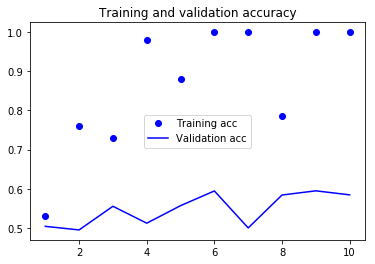

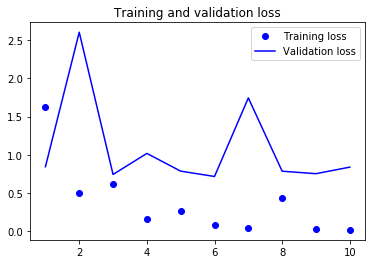

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Without pre-trained embeddings

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6950 - acc: 0.5250 - val_loss: 0.6915 - val_acc: 0.5254
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5099 - a

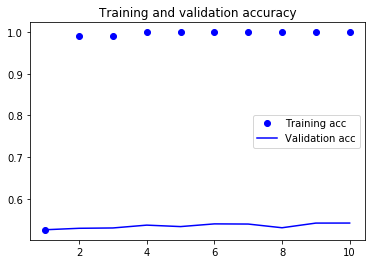

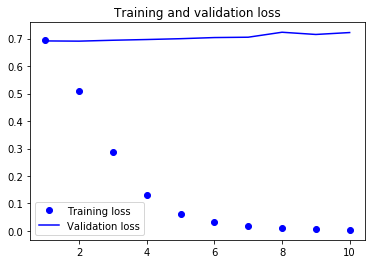

In [ ]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()